In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import random
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

import xgboost as xgb
from xgboost import XGBClassifier

import imblearn

import shap
shap.initjs()


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("whitegrid")

C:\Users\Sonia\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


# Load Data

In [2]:
df_cus = pd.read_csv('../data/churn_dataset.csv')
df_cus = df_cus.loc[(df_cus.first_order_created_datetime >= "2017-01-01") & (df_cus.last_order_created_datetime < "2018-09-30")]

In [3]:
df_ord = pd.read_csv('../data/order_churn_data.csv')
df_ord = df_ord.merge(df_cus[['customer_db_id', 'completed_orders', 'laundry_distance', 'laundry_within_1km']], on='customer_db_id', how='inner')

df_ord['order_created_datetime'] = pd.to_datetime(df_ord.order_created_datetime)
df_ord.pickup_timeslot_from_datetime = pd.to_datetime(df_ord.pickup_timeslot_from_datetime)
df_ord.pickup_timeslot_to_datetime = pd.to_datetime(df_ord.pickup_timeslot_to_datetime)

df_ord['pickup_timeslot_from'] = df_ord.pickup_timeslot_from_datetime.dt.hour
df_ord['pickup_timeslot_to'] = df_ord.pickup_timeslot_to_datetime.dt.hour

df_ord.loc[df_ord.corporate, 'service_class'] = 'CORP'
df_ord['service_class_paid'] = False
df_ord.loc[df_ord.service_class.isin(['EXPRESS', 'PLUS']), 'service_class_paid'] = True

df_ord.voucher_revenue_ratio = df_ord.voucher_revenue_ratio.round(1)

In [4]:
df_items = pd.read_csv('../data/input/items.csv')[['order_id', 'product_group', 'quantity']]
df_items = df_items.groupby(['order_id', 'product_group']).max().unstack().fillna(0)
df_items.columns = ['prod_' + c for c in df_items.columns.get_level_values(1)]
df_items = pd.DataFrame(df_items.to_records())
df_ord = df_ord.merge(df_items, on='order_id', how='left')

In [5]:
df_clusters = pd.read_csv('../data/input/item_clusters_cities.csv')
# df_clusters['cluster'] = df_clusters.cluster.apply(lambda x: int(x[-1])).astype(int)
df_ord = df_ord.drop(['cluster'], axis=1).merge(df_clusters, on='order_id', how='left')

In [6]:
df_ord.head()

,order_id,customer_db_id,order_db_id,order_x,order_y,pickup_timeslot_from_datetime,pickup_timeslot_to_datetime,pickup_zip,order_state,order_created_datetime,...,prod_Shorts,prod_Skirt,prod_Skiwear,prod_Suit,prod_Top,prod_Trousers,prod_Tshirt,prod_Underwear,prod_WashFold,cluster
0,DE-A-00061,5a1ee6e144770903118b466f,5b69531a19207a30fd59e8af,52.491111,13.429692,2018-08-08 09:00:00,2018-08-08 10:00:00,12047,completed,2018-08-07 10:06:50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B_1
1,DE-B-20696,5a1ee6e144770903118b466f,5abe2737467709f94e8b4695,52.491111,13.429692,2018-04-04 06:00:00,2018-04-04 07:00:00,12047,completed,2018-03-30 14:01:59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,B_1
2,DE-B-72139,5a1ee6e144770903118b466f,5b8a56d5ee1b6a373e38f39c,52.491111,13.429692,2018-09-03 10:00:00,2018-09-03 11:00:00,12047,completed,2018-09-01 11:07:33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B_1
3,DE-B-87918,5a1ee6e144770903118b466f,5afc6c33c3436275d6724815,52.491111,13.429692,2018-05-22 07:00:00,2018-05-22 08:00:00,12047,completed,2018-05-16 19:36:51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,B_1
4,DE-C-27253,5a1ee6e144770903118b466f,5b20cb79ee1b6a090e115c25,52.491111,13.429692,2018-06-16 12:00:00,2018-06-16 13:00:00,12047,completed,2018-06-13 09:44:57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B_1


In [7]:
sorted(df_ord.columns.tolist())

['activity_state',
 'aov',
 'churn_factor',
 'city',
 'cluster',
 'cluster_name',
 'completed_orders',
 'corporate',
 'customer_db_id',
 'customer_id',
 'customer_rescheduled',
 'days_since_last_order',
 'days_until_next_order',
 'delay_mins_DO',
 'delay_mins_PU',
 'driver_db_id_DO',
 'driver_db_id_PU',
 'email',
 'fac_name',
 'final_click_channel',
 'final_click_no_voucher',
 'frequency',
 'gender',
 'internal_rescheduled',
 'last_order',
 'laundry_distance',
 'laundry_within_1km',
 'newsletter_optin',
 'num_customer_reschedules',
 'num_internal_reschedules',
 'num_orders',
 'order_created_datetime',
 'order_db_id',
 'order_id',
 'order_num',
 'order_state',
 'order_x',
 'order_y',
 'origin',
 'pickup_timeslot_from',
 'pickup_timeslot_from_datetime',
 'pickup_timeslot_to',
 'pickup_timeslot_to_datetime',
 'pickup_zip',
 'prod_Accessories',
 'prod_Blazer',
 'prod_Blouse',
 'prod_Coats',
 'prod_Dress',
 'prod_DressSpecial',
 'prod_Household',
 'prod_Knitwear',
 'prod_Others',
 'prod_Shirt',
 'prod_Shorts',
 'prod_Skirt',
 'prod_Skiwear',
 'prod_Suit',
 'prod_Top',
 'prod_Trousers',
 'prod_Tshirt',
 'prod_Underwear',
 'prod_WashFold',
 'product_DC',
 'product_HH',
 'product_LA',
 'product_WF',
 'product_combinations',
 'product_type',
 'punctual_5min_DO',
 'punctual_5min_PU',
 'punctual_order',
 'rating',
 'rating_cleaning_quality',
 'rating_damaged_item',
 'rating_driver_conduct',
 'rating_ironing_quality',
 'rating_missing_items',
 'rating_punctuality',
 'recency',
 'reclean_order',
 'referred',
 'refund_approved',
 'refund_liability',
 'refund_request',
 'refund_type',
 'revenue',
 'segment',
 'service_class',
 'service_class_paid',
 'software_type',
 'voucher_channel',
 'voucher_revenue_ratio',
 'voucher_used',
 'voucher_value']

# Create Dataset
- only completed orders
- customers with at least 1 completed order
- calculate frequencies between completed orders

In [8]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
# df_comp = df_ord.loc[(df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])

# number completed orders
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()

# days
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days
df_comp['weeks_until_next_comp'] = df_comp.days_until_next_comp // 7
df_comp['weeks_since_last_comp'] = df_comp.days_since_last_comp // 7

# frequency

df_comp['frequency_days_median'] = df_comp.groupby('customer_db_id')['days_since_last_comp'].transform(lambda x: x.expanding().median())
df_comp['frequency_days_avg'] = df_comp.groupby('customer_db_id')['days_since_last_comp'].transform(lambda x: x.expanding().median())
df_comp['frequency_weeks_median'] = df_comp.groupby('customer_db_id')['weeks_since_last_comp'].transform(lambda x: x.expanding().median())
df_comp['frequency_weeks_diff'] = df_comp.weeks_since_last_comp - df_comp.frequency_weeks_median
df_comp['frequency_weeks_avg'] = df_comp.groupby('customer_db_id')['weeks_since_last_comp'].transform(lambda x: x.expanding().mean())
df_comp['frequency_weeks_std'] = df_comp.groupby('customer_db_id')['weeks_since_last_comp'].transform(lambda x: x.expanding().std())

# revenue
df_comp['revenue_brutto'] = df_comp.revenue + df_comp.voucher_value
df_comp['last_order_revenue_brutto'] = df_comp.groupby('customer_db_id')['revenue_brutto'].shift(1)
df_comp['last_revenue_brutto_diff'] = df_comp.revenue_brutto - df_comp.last_order_revenue_brutto

# cluster
df_comp['last_order_cluster'] = df_comp.groupby(['customer_db_id'])['cluster'].shift(1)
df_comp['cluster_changed'] = (df_comp.cluster == df_comp.last_order_cluster)

df_comp['gender'] = df_comp.gender.map({'male': -1, 'female': 1}).fillna(0)
df_comp['num_products'] = df_comp[[c for c in df_comp.columns if 'prod_' in c]].sum()
df_comp['revenue_per_product'] = df_comp.revenue_brutto / df_comp.num_products
df_comp['over_frequency_days'] = df_comp.days_since_last_comp / df_comp.frequency_days_avg

df_comp = df_comp.drop(['next_order_date', 'last_order_date', 'last_order_revenue_brutto'], axis=1)

In [9]:
# frequencies per each cluster, calcualted based on all customers
cluster_frequencies = df_comp.groupby('cluster').agg({'days_until_next_comp': 'median',
                                                           'weeks_until_next_comp': 'median'}).reset_index()
cluster_frequencies = cluster_frequencies.rename(columns={'days_until_next_comp': 'cluster_median_freq_days',
                                                          'weeks_until_next_comp': 'cluster_median_freq_weeks'})
df_comp = df_comp.merge(cluster_frequencies, on='cluster', how='left')

In [10]:
df_comp.to_csv('../data/old/comp_orders.csv', index=False)
df_comp.head()

,order_id,customer_db_id,order_db_id,order_x,order_y,pickup_timeslot_from_datetime,pickup_timeslot_to_datetime,pickup_zip,order_state,order_created_datetime,...,frequency_weeks_std,revenue_brutto,last_revenue_brutto_diff,last_order_cluster,cluster_changed,num_products,revenue_per_product,over_frequency_days,cluster_median_freq_days,cluster_median_freq_weeks
0,GB-W-59043,55e442dfd2cde8c51ec4d4a7,596214c2447709aa7c8b46c7,NaN,NaN,2017-07-09 18:30:00,2017-07-09 19:00:00,NW6 1QD,completed,2017-07-09 12:34:26,...,NaN,131.213242,NaN,NaN,False,NaN,NaN,NaN,22.0,3.0
1,GB-L-89887,5607e33cd4cde8db38c8d25c,58c3babb467709ea298b46ad,51.486661,0.033602,2017-03-12 19:30:00,2017-03-12 20:00:00,SE7 8AY,completed,2017-03-11 08:52:11,...,NaN,16.703310,NaN,NaN,False,NaN,NaN,NaN,15.0,2.0
2,GB-S-33739,56e8cfd2d4cde8b932bae6a9,5904c69c4577094a458b45fb,51.470018,-0.139703,2017-04-30 12:00:00,2017-04-30 12:30:00,SW8 3JD,completed,2017-04-29 18:00:12,...,NaN,60.091564,NaN,NaN,False,NaN,NaN,NaN,17.0,2.0
3,GB-B-78803,56e8cfd2d4cde8b932bae6a9,5941223e457709913d8b45c3,51.470018,-0.139703,2017-06-15 10:00:00,2017-06-15 10:30:00,SW8 3JD,completed,2017-06-14 12:47:10,...,NaN,54.067936,-6.023627,L_1,False,NaN,NaN,1.000000,14.0,2.0
4,GB-H-60995,56e8cfd2d4cde8b932bae6a9,59709c45457709413c8b456a,51.470018,-0.139703,2017-07-21 10:30:00,2017-07-21 11:00:00,SW8 3JD,completed,2017-07-20 13:04:21,...,0.707107,33.039048,-21.028888,L_6,True,NaN,NaN,0.888889,14.0,2.0


# Filter Data
- per city
- only active customers
- orders where the next completed order within 2 and 150 days
- orders where last completed order within 2 and 150 days
- exclude corporate


# Dataset

In [11]:
num_completed_orders = 3
days_min = df_comp.days_until_next_comp.quantile(0.05)
days_max = df_comp.days_until_next_comp.quantile(0.95)
city = 'London'

In [12]:
days_min = 1
days_max = 60

In [13]:
cust_ids_excl = df_comp.loc[(df_comp.city != city) |
                            (df_comp.days_until_next_comp > days_max) | (df_comp.days_until_next_comp < days_min) |
                            (df_comp.days_since_last_comp > days_max) | (df_comp.days_since_last_comp < days_min) |
                            (df_comp.corporate) | (df_comp.voucher_channel.str.contains('CC|cc')) |
                            (df_comp.completed_orders < num_completed_orders)].customer_db_id.unique().tolist()
print(len(cust_ids_excl), '/', df_comp.customer_db_id.nunique())

28949 / 30175


In [14]:
df_city = df_comp.loc[~(df_comp.customer_db_id.isin(cust_ids_excl))]
df_city = df_city.loc[df_city.order_comp_num < num_completed_orders]

In [15]:
print('Num orders:', df_city.order_id.nunique())
print('Num customers:', df_city.customer_db_id.nunique())

Num orders: 3678
Num customers: 1226


In [16]:
known_cust = df_city[df_city.completed_orders > num_completed_orders].customer_db_id.unique()
unknown_cust = df_city[df_city.completed_orders == num_completed_orders].customer_db_id.unique()

df_known = df_city.loc[df_city.customer_db_id.isin(known_cust)]
df_unknown = df_city.loc[df_city.customer_db_id.isin(unknown_cust)]

In [17]:
print('Known customers:', len(known_cust))
print('Unknown customers:', len(unknown_cust))

Known customers: 828
Unknown customers: 398


In [18]:
df_known.order_id.nunique()

2484

In [19]:
df_known['days_until_next_comp_bin_cat'] = pd.qcut(df_known.days_until_next_comp.sort_values(), 10)
df_known['days_until_next_comp_bin'], bins = pd.qcut(df_known.days_until_next_comp.sort_values(), 10, labels=False, retbins=True)

In [20]:
df_known['days_since_last_comp_bin'] = pd.cut(df_known.days_since_last_comp.sort_values(), labels=False, 
                                              include_lowest=True, bins=bins)

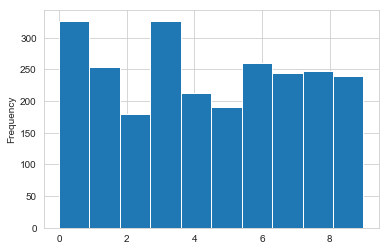

In [21]:
df_known.days_until_next_comp_bin.plot(kind='hist', bins=10)

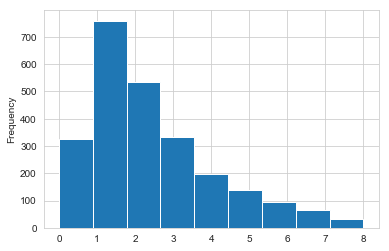

In [22]:
df_known.weeks_until_next_comp.plot(kind='hist', bins=df_known.weeks_until_next_comp.nunique())

In [23]:
cust_sample = random.sample(df_known.loc[df_known.completed_orders > 10].customer_db_id.unique().tolist(), 10)
cust_sample

['5960c90e467709032d8b4598',
 '590e2fe2457709a94c8b457b',
 '598f178d45770920698b457e',
 '591aa7af44770910318b467e',
 '59b7afcd45770938258b4661',
 '59dbba0f4577092e4c8b46b2',
 '58d6a32c457709ba128b4617',
 '5a9fdf8044770990148b4750',
 '5880bf654677095b228b45e7',
 '587b93e6457709b2638b46a5']

In [24]:
def plot_customer(customer_db_id):
    fig, ax= plt.subplots(figsize=(10,5))
    df_cust = df_comp.loc[df_comp.customer_db_id == customer_db_id]
    sns.lineplot(data=df_cust, x='order_num', y='days_until_next_comp', ax=ax)

In [25]:
cust_sample[5]

'59dbba0f4577092e4c8b46b2'

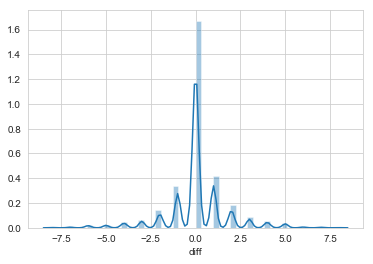

In [26]:
diff = df_known[['weeks_until_next_comp', 'weeks_since_last_comp']]
diff['diff'] = (df_known.weeks_until_next_comp - df_known.weeks_since_last_comp).fillna(0)
sns.distplot(diff['diff'])

weeks_since_last_comp
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
2.0    AxesSubplot(0.125,0.125;0.775x0.755)
3.0    AxesSubplot(0.125,0.125;0.775x0.755)
4.0    AxesSubplot(0.125,0.125;0.775x0.755)
5.0    AxesSubplot(0.125,0.125;0.775x0.755)
6.0    AxesSubplot(0.125,0.125;0.775x0.755)
7.0    AxesSubplot(0.125,0.125;0.775x0.755)
8.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: diff, dtype: object

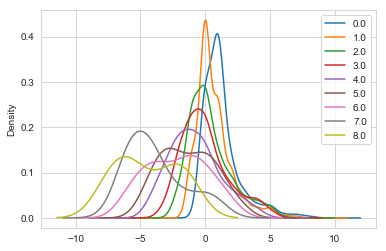

In [27]:
diff.groupby('weeks_since_last_comp')['diff'].plot(kind='kde', legend=True)

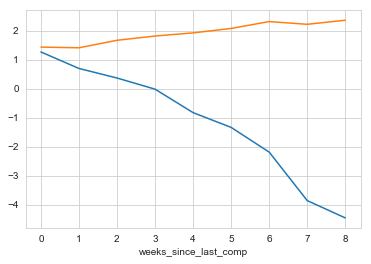

In [28]:
diff.groupby('weeks_since_last_comp')['diff'].mean().plot()
diff.groupby('weeks_since_last_comp')['diff'].std().plot()

In [29]:
week_mean_diff = diff.groupby('weeks_since_last_comp')['diff'].mean()
week_mean_diff

weeks_since_last_comp
0.0    1.264706
1.0    0.695825
2.0    0.366197
3.0   -0.018018
4.0   -0.827869
5.0   -1.336735
6.0   -2.189655
7.0   -3.861111
8.0   -4.458333
Name: diff, dtype: float64

In [30]:
df_known_0 = df_known.loc[df_known.order_comp_num == 0, 'days_until_next_comp'].values
df_known_1 = df_known.loc[df_known.order_comp_num == 1, 'days_until_next_comp'].values

diff_freq = df_known_0 - df_known_1
diff_freq = pd.Series(diff_freq)
diff_freq.describe()

count    828.000000
mean      -0.727053
std       13.699324
min      -47.000000
25%       -7.000000
50%       -1.000000
75%        5.000000
max       53.000000
dtype: float64

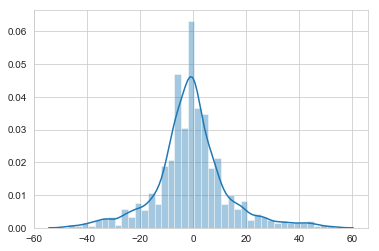

In [31]:
sns.distplot(diff_freq)

In [32]:
df_known.groupby(['order_comp_num'])['days_until_next_comp'].describe()

,count,mean,std,min,25%,50%,75%,max
order_comp_num,,,,,,,,
0,828.0,18.042271,13.014712,1.0,8.0,14.0,25.25,60.0
1,828.0,18.769324,12.405821,1.0,9.0,15.0,24.25,58.0
2,828.0,19.490338,13.217414,1.0,9.0,16.0,26.00,60.0


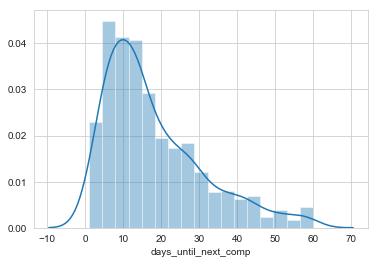

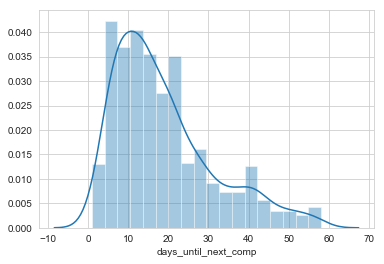

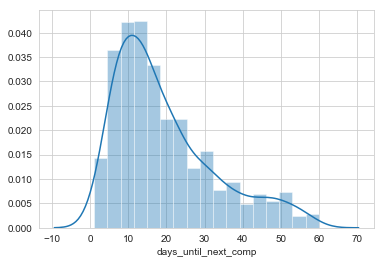

In [33]:
for o in range(3):
    plt.figure()
    sns.distplot(df_known.loc[df_known.order_comp_num == o, 'days_until_next_comp'])

# Select Features
into customer features, prior features and last order features

In [34]:
df_known.shape

(2484, 118)

In [35]:
feats = [
    # behaviour
    'revenue_brutto', 'voucher_revenue_ratio', 'service_class_paid',
    'voucher_used', 'voucher_channel', 'software_type',
    'final_click_channel', 'frequency_weeks_median', 'frequency_weeks_diff',
    'weeks_since_last_comp', 'days_since_last_comp', 'frequency_days_median',
    'cluster_median_freq_weeks', 'last_revenue_brutto_diff', 'frequency_weeks_avg',
#    'days_since_last_comp_bin',
    
    # items
    'cluster', 'laundry_distance', 'laundry_within_1km', 'cluster_changed',
    'num_products', 'revenue_per_product', 'over_frequency_days']

# feats_prior = ['revenue_brutto', 'days_since_last_comp', 'weeks_since_last_comp', 'frequency_weeks_avg']

feats_prod = [c for c in df_known.columns if 'prod_' in c]
# feats_prod = []

pred_name = 'weeks_until_next_comp'
baseline_name = 'weeks_since_last_comp'

# Fill NA

In [36]:
nans = df_known[feats].isnull().sum()
nans[nans > 0].sort_values(ascending=False)

revenue_per_product         2484
num_products                2484
voucher_channel             2125
over_frequency_days          828
frequency_weeks_avg          828
last_revenue_brutto_diff     828
frequency_days_median        828
days_since_last_comp         828
weeks_since_last_comp        828
frequency_weeks_diff         828
frequency_weeks_median       828
laundry_within_1km           156
laundry_distance             156
dtype: int64

In [37]:
df_known.voucher_channel = df_known.voucher_channel.fillna('Unknown')
df_known.laundry_distance = df_known.laundry_distance.fillna(-999)
df_known.laundry_within_1km = df_known.laundry_within_1km.fillna(0)
df_known.frequency_weeks_diff = df_known.frequency_weeks_diff.fillna(0)
df_known.frequency_weeks_median = df_known.frequency_weeks_median.fillna(0)
df_known.cluster = df_known.cluster.fillna('0')
df_known.weeks_since_last_comp = df_known.weeks_since_last_comp.fillna(-1)
df_known.days_since_last_comp = df_known.days_since_last_comp.fillna(-1)
df_known.days_since_last_comp_bin = df_known.days_since_last_comp_bin.fillna(-1)
df_known.software_type = df_known.software_type.fillna('Unknown')
df_known.frequency_days_median = df_known.frequency_days_median.fillna(-1)
df_known[nans.index.tolist()] = df_known[nans.index.tolist()].fillna(0)

df_known[baseline_name] = df_known[baseline_name].fillna(0)

# Encode

In [38]:
str_cols = df_known[feats].select_dtypes(include='object').columns
df_known[str_cols] = df_known[str_cols].apply(LabelEncoder().fit_transform)

In [39]:
df_known_feats = df_known.set_index(['customer_db_id', 'order_comp_num']).unstack().swaplevel(axis=1)

In [40]:
df_known_last = df_known_feats[num_completed_orders-1][feats + feats_prod + [pred_name]].reset_index()
df_known_last.head()

,customer_db_id,revenue_brutto,voucher_revenue_ratio,service_class_paid,voucher_used,voucher_channel,software_type,final_click_channel,frequency_weeks_median,frequency_weeks_diff,...,prod_Shorts,prod_Skirt,prod_Skiwear,prod_Suit,prod_Top,prod_Trousers,prod_Tshirt,prod_Underwear,prod_WashFold,weeks_until_next_comp
0,56e8cfd2d4cde8b932bae6a9,33.039048,0.0,True,False,12,3,7,5.5,-0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
1,586a563244770900208b464d,17.048702,0.0,True,False,12,0,7,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
2,586a6fc0457709ff638b460f,42.023624,0.2,True,True,2,1,5,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0
3,586ab322457709c2698b4692,59.319001,0.0,False,False,12,3,7,5.0,2.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0
4,586cb22c467709ea3a8b45b2,26.169012,0.0,False,False,12,3,4,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [41]:
df_known_last = df_known_last.fillna(-1)

In [42]:
df_known_prior = df_known_feats[list(range(num_completed_orders-1))]
df_known_prior = df_known_prior.swaplevel(axis=1)
df_known_prior = df_known_prior[feats + [pred_name]].fillna(-1)

df_known_prior = pd.DataFrame(df_known_prior.to_records())
df_known_prior.head()

,customer_db_id,"('revenue_brutto', 0)","('revenue_brutto', 1)","('voucher_revenue_ratio', 0)","('voucher_revenue_ratio', 1)","('service_class_paid', 0)","('service_class_paid', 1)","('voucher_used', 0)","('voucher_used', 1)","('voucher_channel', 0)",...,"('cluster_changed', 0)","('cluster_changed', 1)","('num_products', 0)","('num_products', 1)","('revenue_per_product', 0)","('revenue_per_product', 1)","('over_frequency_days', 0)","('over_frequency_days', 1)","('weeks_until_next_comp', 0)","('weeks_until_next_comp', 1)"
0,56e8cfd2d4cde8b932bae6a9,60.091564,54.067936,0.2,0.0,True,True,True,False,5,...,False,False,0.0,0.0,0.0,0.0,0.0,1.0,6.0,5.0
1,586a563244770900208b464d,14.642013,14.662247,0.0,0.0,False,False,False,False,12,...,False,True,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0
2,586a6fc0457709ff638b460f,24.459439,26.509375,0.0,0.0,False,True,False,False,12,...,False,True,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0
3,586ab322457709c2698b4692,44.902173,100.192397,0.0,0.0,False,False,False,False,12,...,False,False,0.0,0.0,0.0,0.0,0.0,1.0,3.0,7.0
4,586cb22c467709ea3a8b45b2,38.937993,34.030318,0.3,0.0,True,False,True,False,10,...,False,True,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [43]:
df_train = df_known_prior.merge(df_known_last, on='customer_db_id', how='left').set_index(['customer_db_id'])
df_train.head()

,"('revenue_brutto', 0)","('revenue_brutto', 1)","('voucher_revenue_ratio', 0)","('voucher_revenue_ratio', 1)","('service_class_paid', 0)","('service_class_paid', 1)","('voucher_used', 0)","('voucher_used', 1)","('voucher_channel', 0)","('voucher_channel', 1)",...,prod_Shorts,prod_Skirt,prod_Skiwear,prod_Suit,prod_Top,prod_Trousers,prod_Tshirt,prod_Underwear,prod_WashFold,weeks_until_next_comp
customer_db_id,,,,,,,,,,,,,,,,,,,,,
56e8cfd2d4cde8b932bae6a9,60.091564,54.067936,0.2,0.0,True,True,True,False,5,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
586a563244770900208b464d,14.642013,14.662247,0.0,0.0,False,False,False,False,12,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
586a6fc0457709ff638b460f,24.459439,26.509375,0.0,0.0,False,True,False,False,12,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0
586ab322457709c2698b4692,44.902173,100.192397,0.0,0.0,False,False,False,False,12,12,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0
586cb22c467709ea3a8b45b2,38.937993,34.030318,0.3,0.0,True,False,True,False,10,12,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [44]:
# df_known_m = df_known_m.dropna()
df_train.shape

(828, 88)

# Classification (Weeks)

In [45]:
def print_metric(true_y, pred_y, metric=metrics.accuracy_score, metric_name='Accuracy', kwargs=None):
    if not kwargs:
        kwargs = {}
    kwargs['y_true'] = true_y
    kwargs['y_pred'] = pred_y
    print(metric_name + ':', metric(**kwargs).round(5))
    
    return metric(**kwargs)

def print_accuracy(true_y, pred_y):
    print_metric(true_y, pred_y, metrics.accuracy_score, 'Accuracy')
    
def print_f1(true_y, pred_y):
    kwargs = {'average': 'weighted'}
    print_metric(true_y, pred_y, metrics.f1_score, 'F1 Score', kwargs)
    
def print_mse(true_y, pred_y):
    print_metric(true_y, pred_y, metrics.mean_squared_error, 'MSE')

def print_log_loss(true_y, pred_y):
    print_metric(true_y, pred_y, metrics.log_loss, 'Log Loss')
    
def print_r2_score(true_y, pred_y):
    print_metric(true_y, pred_y, metrics.r2_score)
    
def plot_confusion_mat(true_y, pred_y):
    sns.heatmap(metrics.confusion_matrix(true_y, pred_y))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
def print_score(score, score_name):
    score = np.array(score)
    print(score_name + ':', "%0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))
    
f1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
acc_scorer = metrics.make_scorer(metrics.accuracy_score)
r2_scorer = metrics.make_scorer(metrics.r2_score)

# Baseline
Predict the number since last order as until next order.

In [46]:
print_accuracy(df_known_last[pred_name], df_known_last[baseline_name])
print_f1(df_known_last[pred_name], df_known_last[baseline_name])
print_mse(df_known_last[pred_name], df_known_last[baseline_name])

Accuracy: 0.31401
F1 Score: 0.31249
MSE: 4.20652


In [47]:
print_accuracy(df_known_last[pred_name], df_known_last['frequency_weeks_avg'].round())
print_f1(df_known_last[pred_name], df_known_last['frequency_weeks_avg'].round())
print_mse(df_known_last[pred_name], df_known_last['frequency_weeks_avg'])

Accuracy: 0.26812
F1 Score: 0.25743
MSE: 3.51238


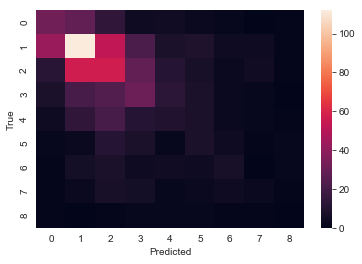

In [48]:
plot_confusion_mat(df_known_last[pred_name], df_known_last[baseline_name])

# Cross-Validation

In [49]:
X = df_train.drop(pred_name, axis=1).values
y = df_train[pred_name].values
n_classes = df_train[pred_name].nunique()
print('X:', X.shape)
print('y:', y.shape)
print('# Classes:', n_classes)

X: (828, 87)
y: (828,)
# Classes: 9


In [50]:
# one-vs-all (OVL)
ovl_class = [0, 1, 2, 3]
df_train_ovl_others = df_train.loc[~df_train[pred_name].isin(ovl_class)]
df_train_ovl_class = df_train.loc[df_train[pred_name].isin(ovl_class)].sample(len(df_train_ovl_others))
# df_train_ovl_class = df_train.loc[df_train[pred_name].isin(ovl_class)]
# df_train_ovl_others = df_train.loc[~df_train[pred_name].isin(ovl_class)].sample(len(df_train_ovl_class))
df_train_ovl = df_train_ovl_class.append(df_train_ovl_others)

X_ovl = df_train_ovl.drop(pred_name, axis=1).values
y_ovl = (df_train_ovl[pred_name].isin(ovl_class)).values.astype(int)
print('X_ovl', X_ovl.shape)
print('y_ovl', y_ovl.shape)

X_ovl (384, 87)
y_ovl (384,)


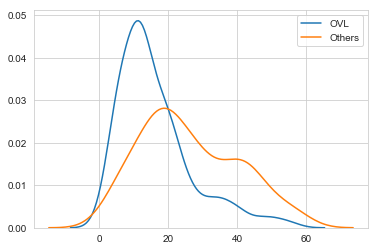

In [51]:
sns.kdeplot(df_train_ovl_class.days_since_last_comp, label='OVL')
sns.kdeplot(df_train_ovl_others.days_since_last_comp, label='Others')

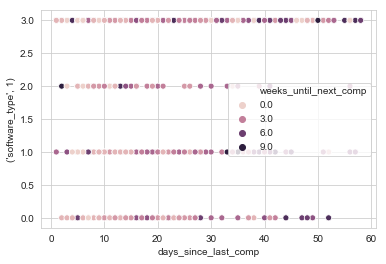

In [52]:
sns.scatterplot(data=df_train, x='days_since_last_comp', y="('software_type', 1)", hue=pred_name)

In [85]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X_norm_ovl = scaler.fit_transform(X_ovl)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.1, random_state=42)
X_train_ovl, X_test_ovl, y_train_ovl, y_test_ovl = train_test_split(X_norm_ovl, y_ovl, test_size=0.1, random_state=42)

binarizer = LabelBinarizer()
y_binary = binarizer.fit_transform(y)

In [86]:
# Cross-Validation
kf = StratifiedKFold(n_splits=4)
kf.get_n_splits(X_train)

4

In [87]:
kf_ovl = StratifiedKFold(n_splits=4)
kf.get_n_splits(X_train_ovl)

4

In [91]:
def eval_model(clf, X=X_train, y=y_train):
    scores =  {'f1': [], 'acc': [], 'r2': [], 'logloss': []}

    for train, test in kf.split(X, y):
        X_cv_train, X_cv_val = X[train], X[test]
        y_cv_train, y_cv_val = y[train], y[test]

        clf.fit(X_cv_train, y_cv_train)
        y_pred = clf.predict(X_cv_val)
        
        try:
            y_pred_proba = clf.predict_proba(X_cv_val)
            scores['logloss'].append(metrics.log_loss(y_cv_val, y_pred_proba, labels=df_train[pred_name].unique().tolist()))      
        except:
            pass
        
        try:
            scores['f1'].append(metrics.f1_score(y_cv_val, y_pred, average='weighted'))
            scores['acc'].append(metrics.accuracy_score(y_cv_val, y_pred))
            scores['r2'].append(metrics.r2_score(y_cv_val, y_pred))
        except:
            pass

    print_score(scores['acc'], 'Accuracy')
    print_score(scores['r2'], 'R2 Score')
    print_score(scores['f1'], 'F1 Score')
    print_score(scores['logloss'], 'Log Loss')

# Logistic Regression

In [92]:
log_reg = linear_model.LogisticRegression()
eval_model(log_reg, X_train, y_train)

Accuracy: 0.2726 (+/- 0.0290)
R2 Score: -0.3134 (+/- 0.2433)
F1 Score: 0.2419 (+/- 0.0373)
Log Loss: 2.1114 (+/- 0.0851)


In [94]:
log_reg = linear_model.LogisticRegression()
eval_model(log_reg, X_train_ovl, y_train_ovl)

Accuracy: 0.6667 (+/- 0.0679)
R2 Score: -0.3334 (+/- 0.2716)
F1 Score: 0.6661 (+/- 0.0687)
Log Loss: nan (+/- nan)


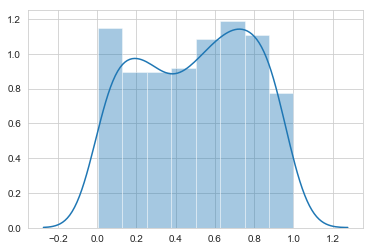

In [59]:
sns.distplot(log_reg.predict_proba(X_norm_ovl)[:, 1])

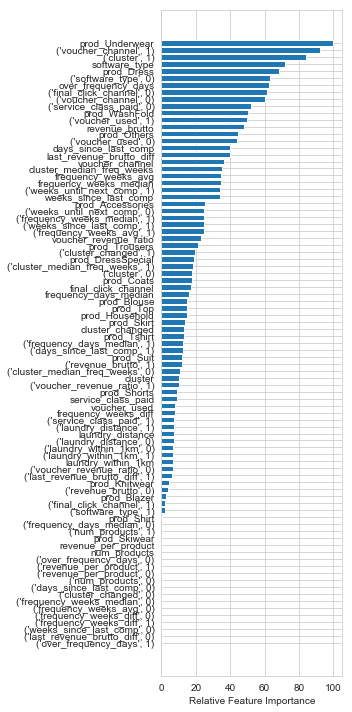

In [60]:
feature_importance = abs(log_reg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(5,10))
ax.barh(pos, feature_importance[sorted_idx])
ax.set_yticks(pos)
ax.set_yticklabels(np.array(df_train.drop(pred_name, axis=1).columns)[sorted_idx])
ax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [61]:
print_accuracy(y_ovl, (log_reg.predict_proba(X_norm_ovl)[:, 1] > 0.70).astype(int))

Accuracy: 0.69531


In [62]:
mlp = MLPClassifier(activation='tanh', alpha=0.1)
eval_model(mlp, X_norm, y)

Accuracy: 0.2876 (+/- 0.0512)
R2 Score: -0.2260 (+/- 0.1502)
F1 Score: 0.2689 (+/- 0.0487)
Log Loss: 2.1622 (+/- 0.1378)


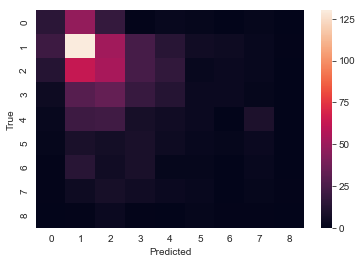

In [63]:
plot_confusion_mat(y, cross_val_predict(mlp, X_norm, y, cv=kf))

In [64]:
lin_svc = svm.SVC()
eval_model(lin_svc, X_norm_ovl, y_ovl)

Accuracy: 0.6719 (+/- 0.0477)
R2 Score: -0.3125 (+/- 0.1909)
F1 Score: 0.6691 (+/- 0.0545)
Log Loss: nan (+/- nan)


In [65]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
eval_model(forest, X_norm, y)

Accuracy: 0.3368 (+/- 0.0400)
R2 Score: -0.0686 (+/- 0.1069)
F1 Score: 0.2601 (+/- 0.0294)
Log Loss: 1.7645 (+/- 0.0584)


Feature ranking:
1. feature frequency_days_median (0.067302)
2. feature ('frequency_days_median', 1) (0.053184)
3. feature ('days_since_last_comp', 1) (0.047412)
4. feature days_since_last_comp (0.042448)
5. feature frequency_weeks_avg (0.042343)
6. feature ('last_revenue_brutto_diff', 1) (0.041286)
7. feature over_frequency_days (0.036439)
8. feature ('revenue_brutto', 1) (0.035137)
9. feature revenue_brutto (0.033915)
10. feature last_revenue_brutto_diff (0.032378)
11. feature frequency_weeks_median (0.030900)
12. feature ('weeks_until_next_comp', 1) (0.029335)
13. feature ('laundry_distance', 0) (0.026368)
14. feature ('revenue_brutto', 0) (0.026128)
15. feature ('laundry_distance', 1) (0.025807)
16. feature weeks_since_last_comp (0.025487)
17. feature prod_Shirt (0.024472)
18. feature laundry_distance (0.019774)
19. feature ('frequency_weeks_avg', 1) (0.019705)
20. feature ('weeks_until_next_comp', 0) (0.018287)
21. feature ('weeks_since_last_comp', 1) (0.018156)
22. feature ('freq

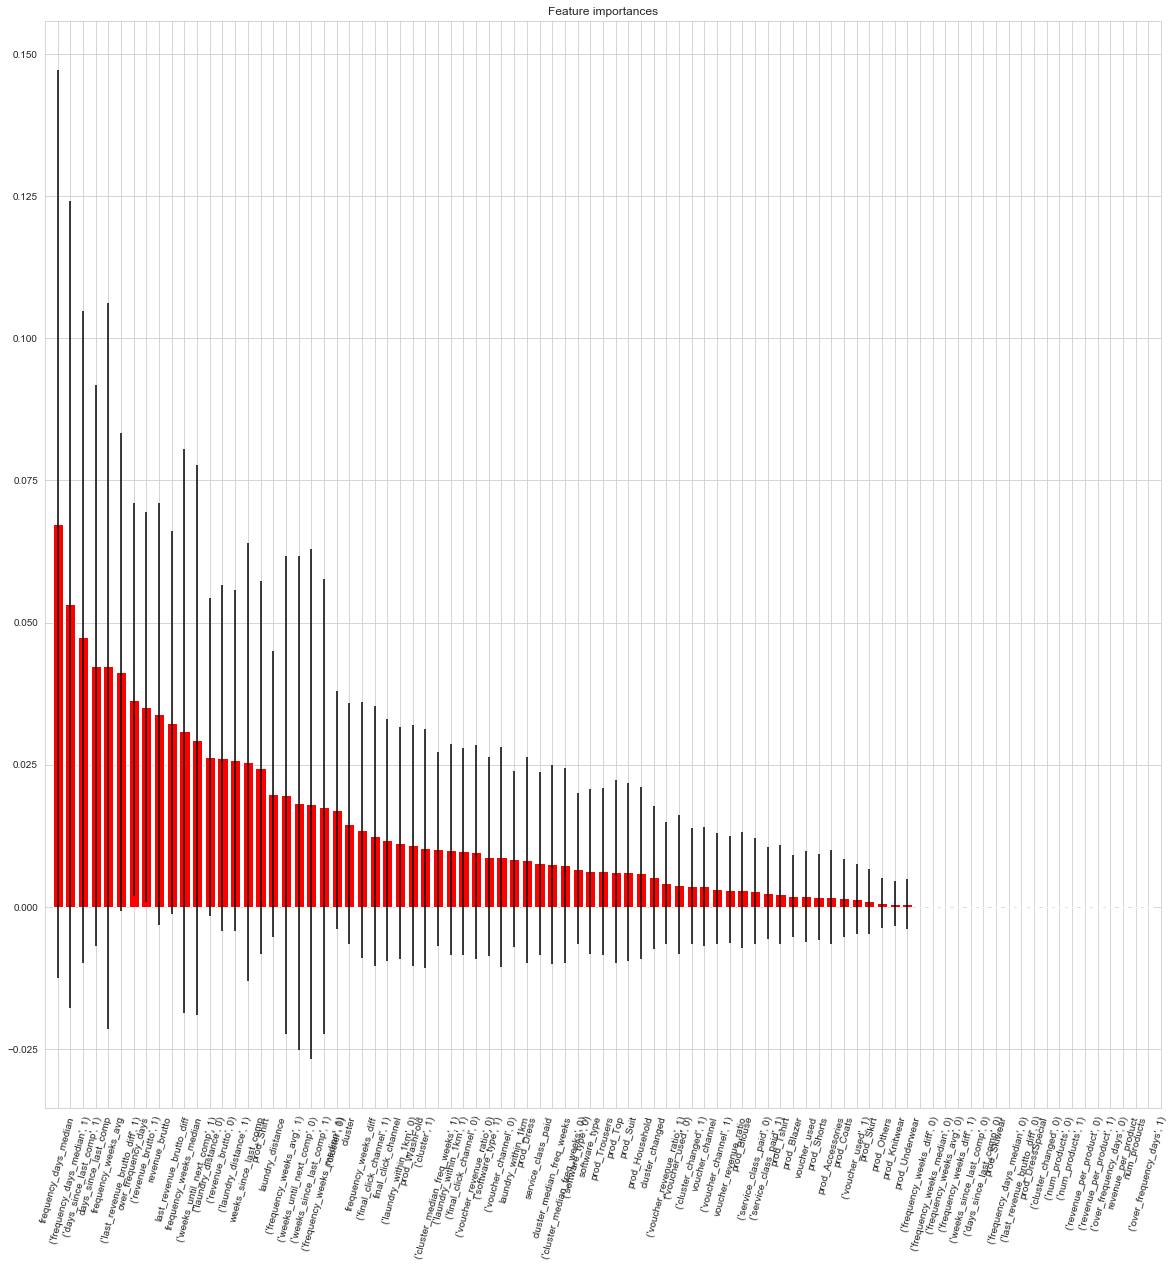

In [66]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
feats = df_train.columns[:-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feats[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,20))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feats[indices], rotation=75)
plt.xlim([-1, X.shape[1]])
plt.show()

In [67]:
forest = RandomForestClassifier(n_estimators=100, max_depth=4)
eval_model(forest, X_norm_ovl, y_ovl)

Accuracy: 0.6797 (+/- 0.0518)
R2 Score: -0.2812 (+/- 0.2073)
F1 Score: 0.6785 (+/- 0.0543)
Log Loss: nan (+/- nan)


In [68]:
neigh = KNeighborsClassifier(n_neighbors=10)
eval_model(neigh, X_norm, y)

Accuracy: 0.3056 (+/- 0.0156)
R2 Score: -0.2585 (+/- 0.1847)
F1 Score: 0.2417 (+/- 0.0196)
Log Loss: 7.2859 (+/- 0.5280)


In [69]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [70]:
neigh = KNeighborsClassifier(n_neighbors=10)
eval_model(neigh, X_norm_ovl, y_ovl)

Accuracy: 0.6667 (+/- 0.0489)
R2 Score: -0.3333 (+/- 0.1954)
F1 Score: 0.6654 (+/- 0.0521)
Log Loss: nan (+/- nan)


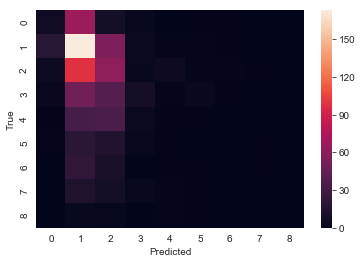

In [71]:
plot_confusion_mat(y, cross_val_predict(neigh, X_norm, y, cv=kf))

In [72]:
model = xgb.XGBClassifier(n_estimators=100,  max_depth=5, gamma=1, feature_names=feats)
eval_model(model)

Accuracy: 0.3019 (+/- 0.0364)
R2 Score: -0.1629 (+/- 0.1026)
F1 Score: 0.2672 (+/- 0.0358)
Log Loss: 1.8633 (+/- 0.0880)


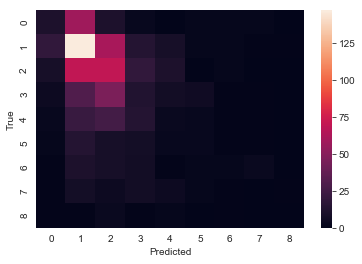

In [73]:
plot_confusion_mat(y, cross_val_predict(model, X_norm, y, cv=kf))

In [74]:
fmap = dict(zip(["f"+str(i) for i in range(len(df_train.drop(pred_name, axis=1).columns))],df_train.columns))

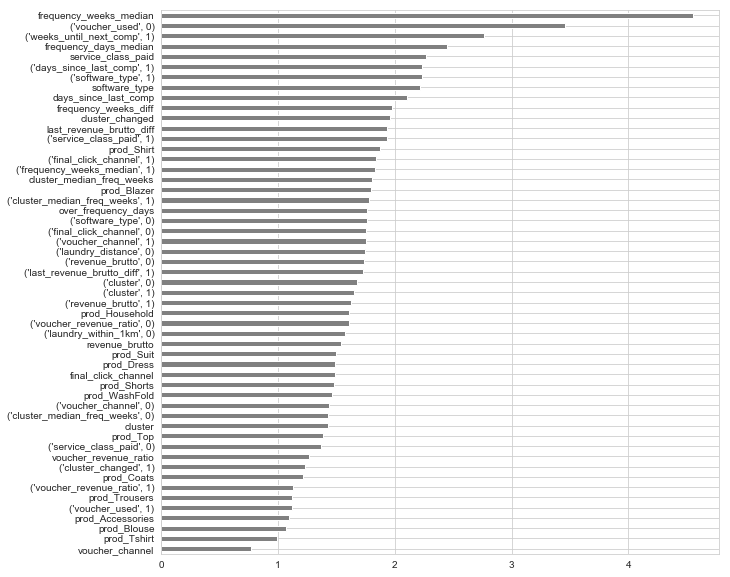

In [75]:
fig, ax = plt.subplots(figsize=(10,10))
df_imp = pd.Series(model.get_booster().get_score(importance_type='gain')).sort_values()
df_imp.index = df_imp.index.map(fmap)
df_imp.plot(kind='barh', color='Gray')